In [1]:
from os.path import join
import matplotlib.pyplot as plt
import earthaccess

import geopandas as gpd
import rasters as rt

from EMITL2ARFL import *

date range

In [2]:
start_date = "2023-04-15"
end_date = "2023-04-15"

download directory

In [3]:
download_directory = "~/data/EMIT_download"

output directory

In [4]:
output_directory = "~/data/Kings Canyon EMIT"

Upper Kings area of interest

In [5]:
gdf = gpd.read_file("upper_kings.kml")
gdf

,Name,Description,geometry
0,0,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...","MULTIPOLYGON Z (((-118.75179 36.85601 0, -118...."


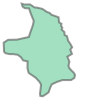

In [6]:
gdf.geometry[0]

In [7]:
bbox_UTM = rt.Polygon(gdf.unary_union).UTM.bbox
bbox_UTM

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_44089/4116591760.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bbox_UTM = rt.Polygon(gdf.unary_union).UTM.bbox


BBox(xmin=878372.1496506371, ymin=4058894.2146899896, xmax=917059.9433665382, ymax=4119262.3546824204, crs="EPSG:32610")

In [8]:
grid = rt.RasterGrid.from_bbox(bbox_UTM, cell_size=60, crs=bbox_UTM.crs)
grid

{
  "dimensions": {
    "rows": 1006,
    "cols": 644
  },
  "bbox": {
    "xmin": 878372.1496506371,
    "ymin": 4058902.3546824204,
    "xmax": 917012.1496506371,
    "ymax": 4119262.3546824204
  },
  "crs": "EPSG:32610",
  "resolution": {
    "cell_width": 60.0,
    "cell_height": -60.0
  }
}

Log into `earthaccess` using `netrc` credentials

In [9]:
earthaccess.login(strategy="netrc", persist=True)

search for EMIT granules covering area of interest

In [10]:
search_results = search_EMIT_L2A_RFL_granules(
    start_UTC=start_date,
    end_UTC=end_date,
    geometry=grid
)

search_results

[Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -119.02839660644531, 'Latitude': 37.37525939941406}, {'Longitude': -119.491455078125, 'Latitude': 36.722076416015625}, {'Longitude': -118.73031616210938, 'Latitude': 36.18247985839844}, {'Longitude': -118.26725769042969, 'Latitude': 36.835662841796875}, {'Longitude': -119.02839660644531, 'Latitude': 37.37525939941406}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-04-15T22:24:20Z', 'EndingDateTime': '2023-04-15T22:24:32Z'}}
 Size(MB): 3582.072193145752
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230415T222420_2310515_007/EMIT_L2A_RFL_001_20230415T222420_2310515_007.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230415T222420_2310515_007/EMIT_L2A_RFLUNCERT_001_20230415T222420_2

download each granule, extract subset projected to target grid, and write to multi-band GeoTIFF

In [11]:
# for search_result in search_results:
#     granule_ID = dict(search_result.items())["meta"]["native-id"]
#     print(granule_ID)
#     output_filename = join(output_directory, f"{granule_ID}.tif")
#     granule = retrieve_EMIT_L2A_RFL_granule(search_result)
#     reflectance = granule.reflectance(geometry=grid)

#     display(reflectance.imshow())

#     print(output_filename)
#     reflectance.to_geotiff(output_filename)

EMIT_L2A_RFL_001_20230415T222420_2310515_007


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

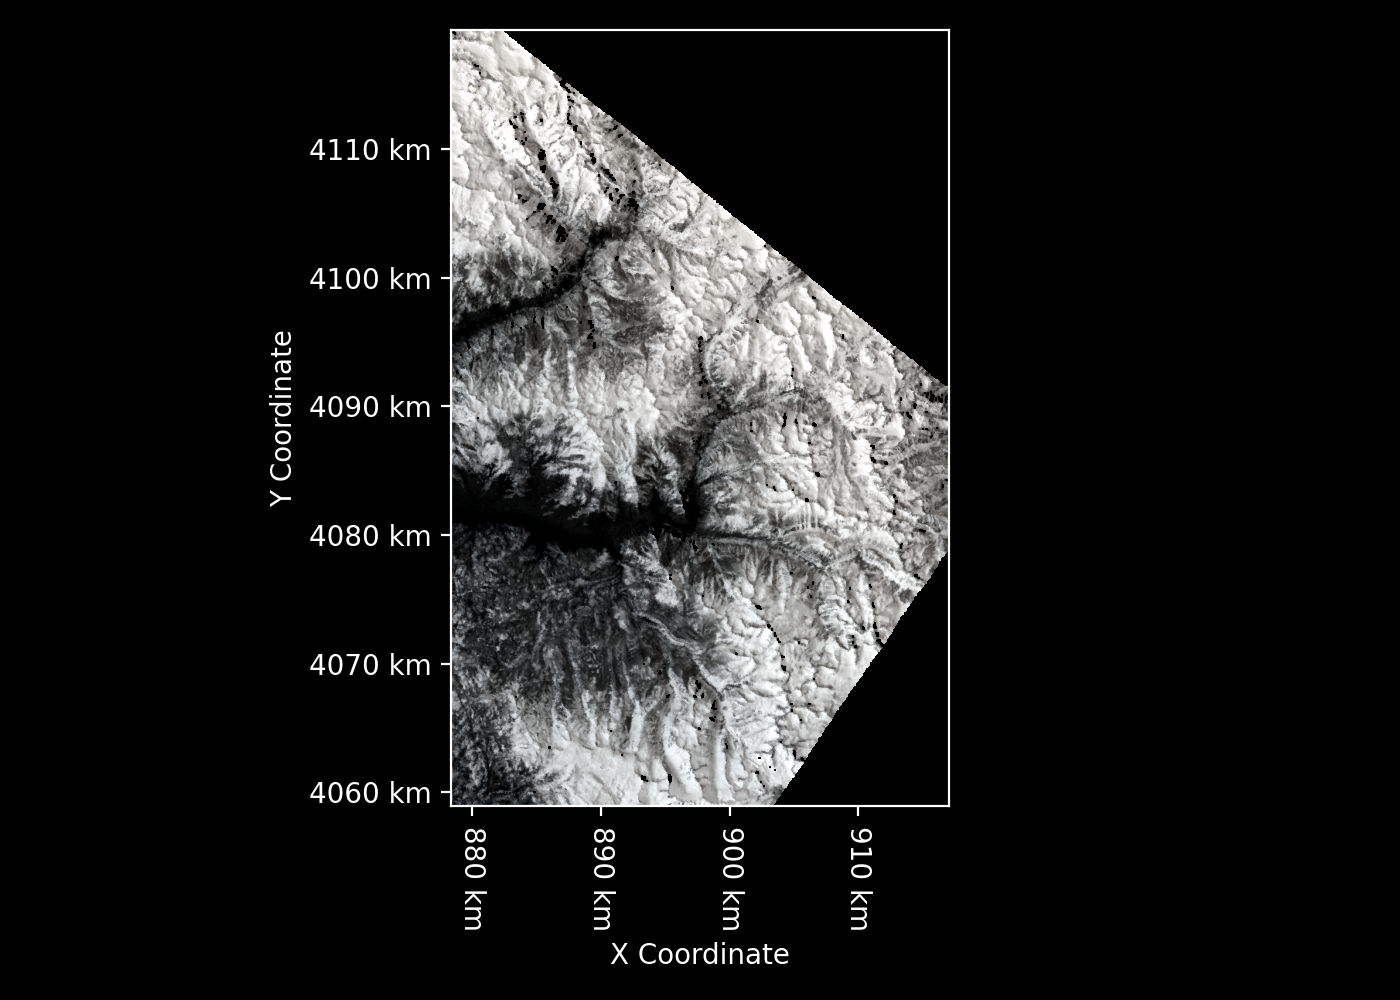

In [12]:
search_result = search_results[0]

granule_ID = dict(search_result.items())["meta"]["native-id"]
print(granule_ID)
output_filename = join(output_directory, f"{granule_ID}.tif")
granule = retrieve_EMIT_L2A_RFL_granule(search_result)
reflectance = granule.reflectance(geometry=grid)

reflectance

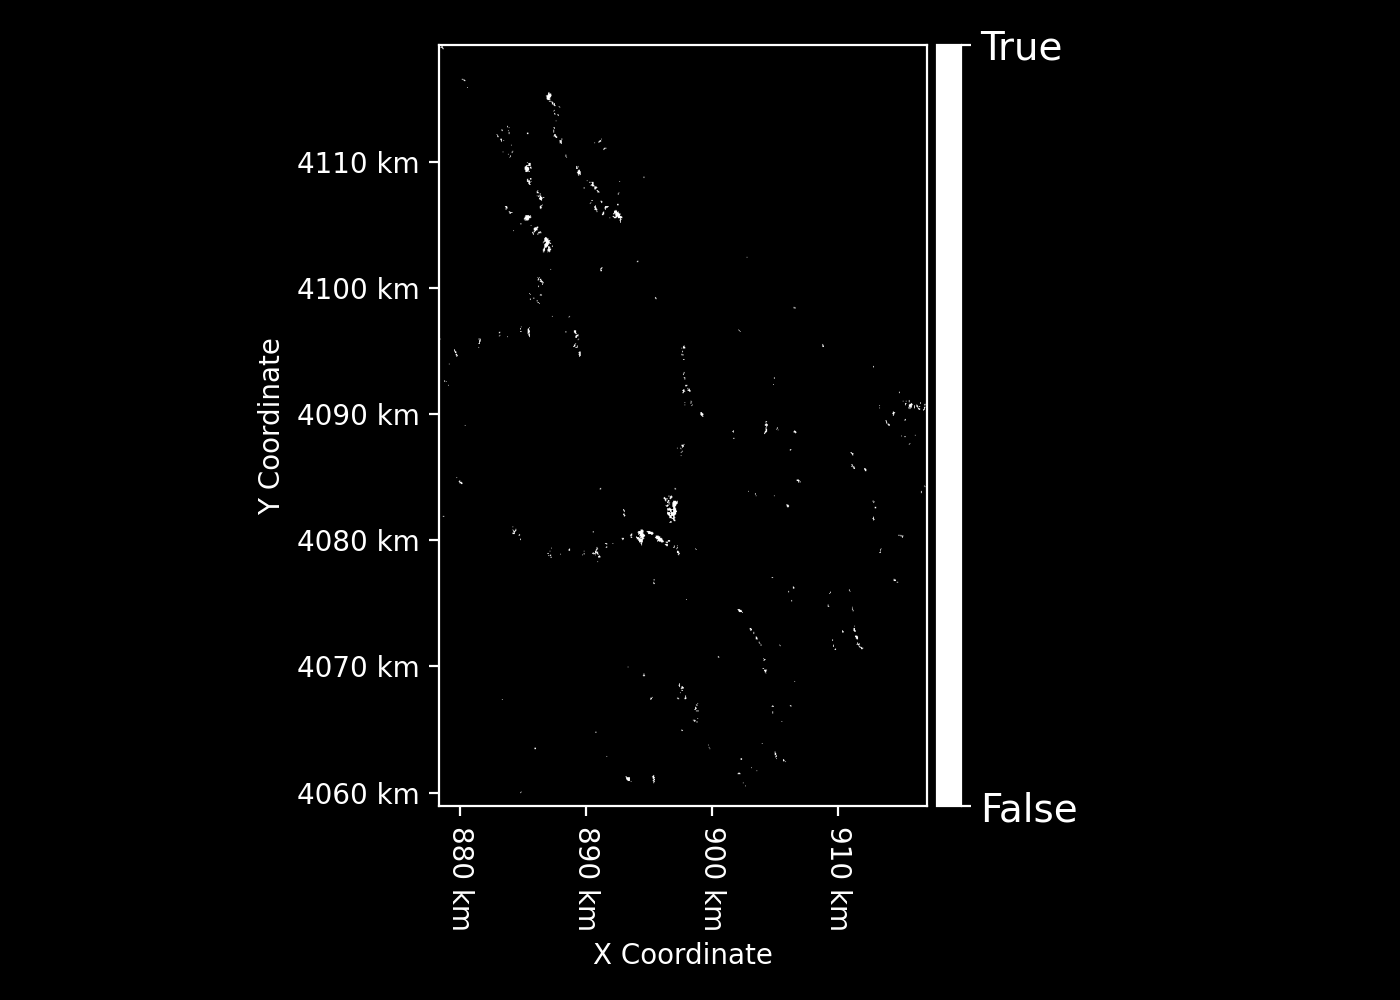

In [13]:
qmask = granule.quality_mask(geometry=grid)
qmask

In [14]:
reflectance.shape

(285, 1006, 644)

In [15]:
qmask.shape

(1006, 644)

In [16]:
qmask.dtype

dtype('bool')

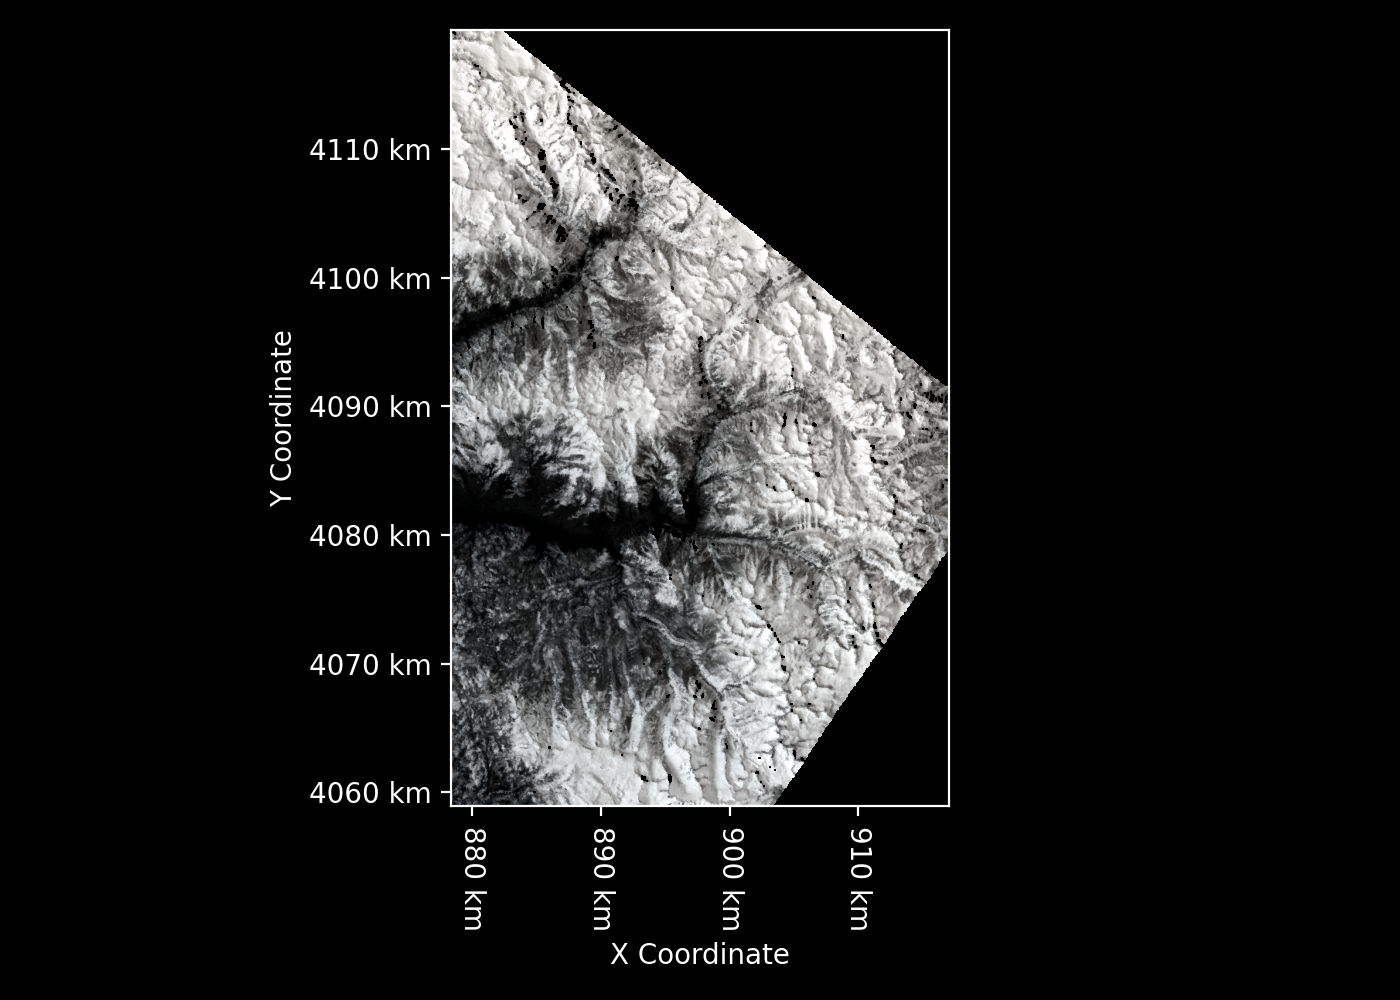

In [17]:
masked_reflectance = reflectance.mask(~qmask)
masked_reflectance

In [18]:
type(qmask.geometry)

rasters.raster_grid.RasterGrid

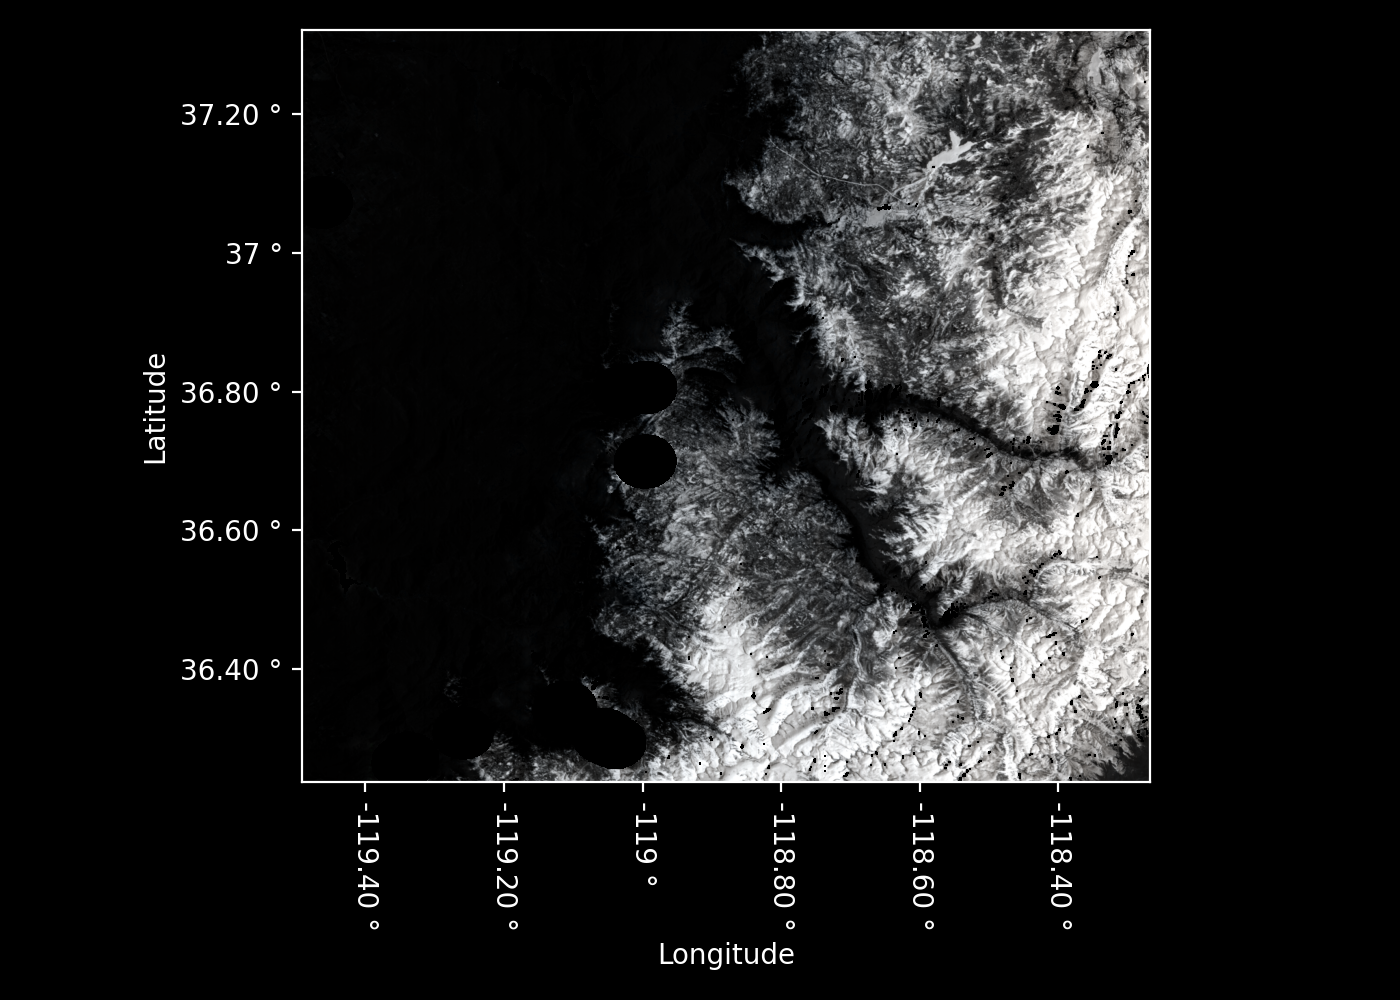

In [19]:
scene_reflectance = granule.reflectance()
scene_reflectance

EMIT_L2A_RFL_001_20230415T222420_2310515_007


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

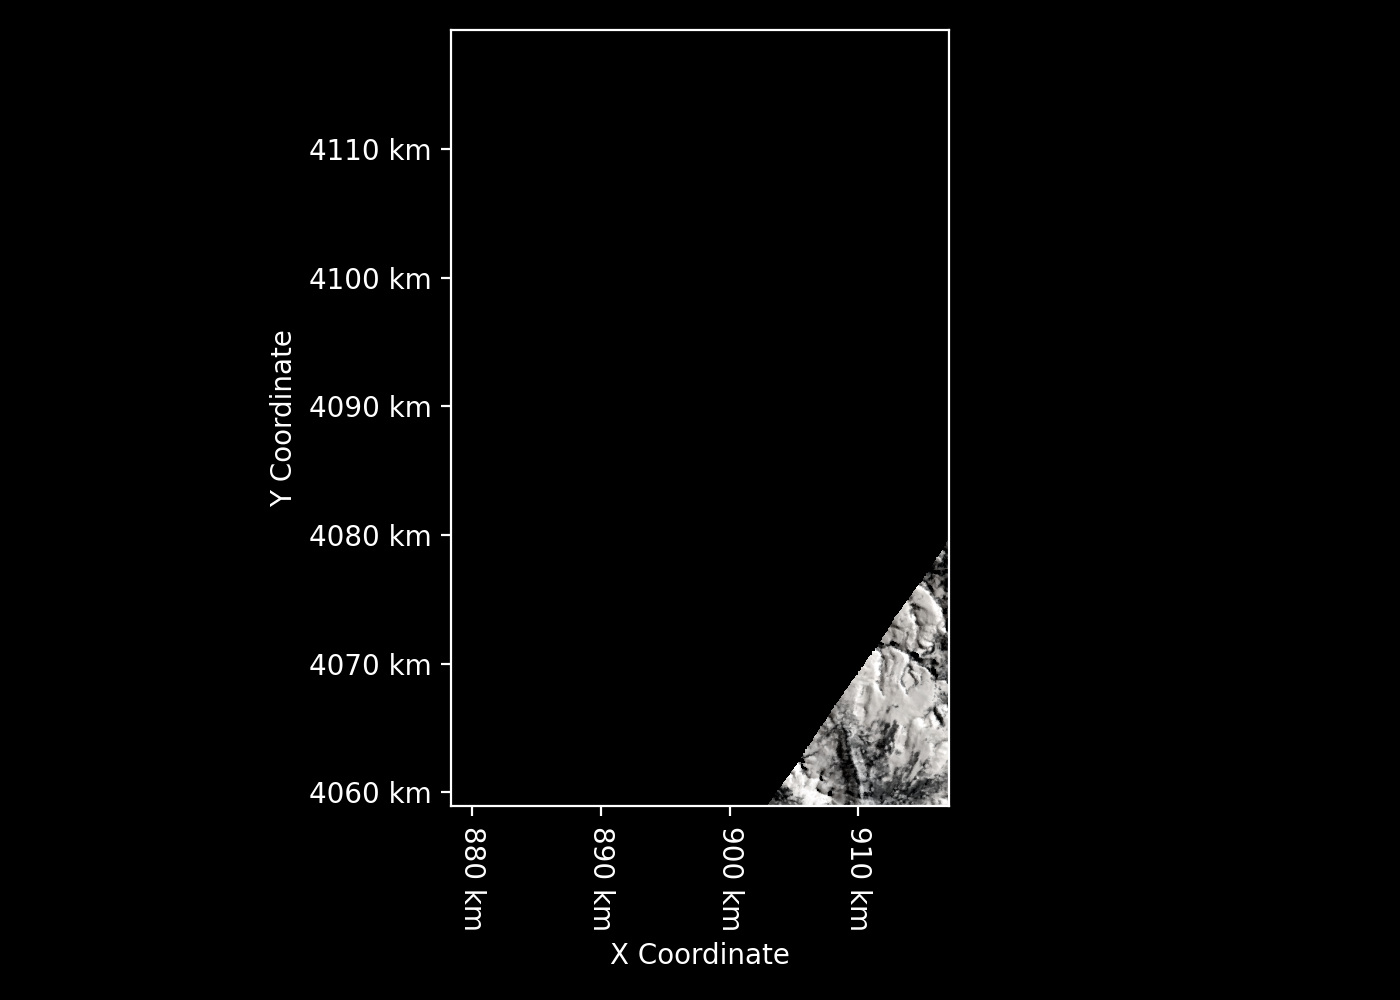

In [20]:
search_result_other = search_results[1]

granule_ID_other = dict(search_result.items())["meta"]["native-id"]
print(granule_ID_other)
output_filename_other = join(output_directory, f"{granule_ID_other}.tif")
granule_other = retrieve_EMIT_L2A_RFL_granule(search_result_other)
reflectance_other = granule_other.reflectance(geometry=grid)

reflectance_other

In [22]:
mosaic = rt.mosaic([reflectance, reflectance_other], geometry=grid)
mosaic

ValueError: data is not a two-dimensional array